# Principle

The idea of spotter is to represent stellar maps using the [HEALPix](https://healpix.sourceforge.io/) subdivision scheme in order to compute their spectra and light curves. The advantage of HEALPix is its equal-area pixels, which simplifies a lot of computations. Here is an example of an HEALPix map

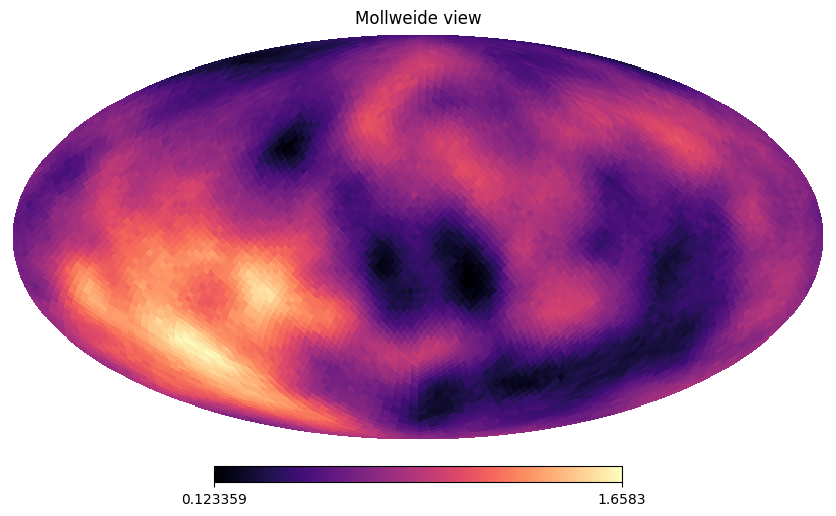

In [1]:
import jax
import numpy as np
import healpy as hp
from spotter import kernels, core, Star


import tinygp
from spotter.kernels import GreatCircleDistance

star = Star.from_sides(26, u=(0.2, 0.1), period=1.0)
kernel = 0.1 * tinygp.kernels.Matern52(0.4, distance=GreatCircleDistance())
gp = tinygp.GaussianProcess(kernel, star.x, mean=1.0)
y = gp.sample(jax.random.PRNGKey(4))
moll_y = hp.mollview(y, return_projected_map=True, cmap="magma")

Using HEALPix, this map simply consists in a flat vector $y$ that contains the values of each pixel (to see how this particular map was generated, check out the [Surface GP tutorial](./surface_gp.ipynb)).

The idea of *spotter* is to compute observables, such as light curves, radial velocities, or spectra, from this kind of maps in a **linear** way. For example, assuming a given inclination and polynomial limb darkening coefficients, the integrated flux of the map can be simply expressed as

$$f = Xy$$

where at a given time, $X$ can be constructed by computing:
- The pixels belonging to the visible hemisphere of the map
- The projected area of each pixel
- The limb darkening intensity of each pixel

Let's visualize these components

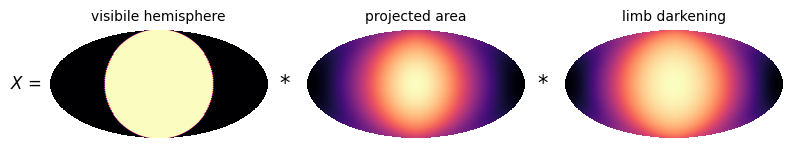

In [2]:
import healpy as hp
from spotter import core
import matplotlib.pyplot as plt

hemisphere, projected, limb = core.mask_projected_limb(star.x, u=star.u[0])


def mollmap(y):
    Y = hp.mollview(y, return_projected_map=True)
    plt.close()
    return Y


hemisphere_y = mollmap(hemisphere)
projected_y = mollmap(projected)
limb_y = mollmap(limb)

cmap = "magma"

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

for a in ax.flatten():
    plt.setp(a.spines.values(), visible=False)
    a.tick_params(left=False, labelleft=False)
    a.tick_params(bottom=False, labelbottom=False)
    a.patch.set_visible(False)

ax[0].imshow(hemisphere_y, origin="lower", cmap=cmap)
ax[0].set_title("visibile hemisphere", fontsize=10)
ax[0].text(
    -0.1,
    0.5,
    "$X$ = ",
    ha="center",
    va="center",
    transform=ax[0].transAxes,
    fontsize=12,
)

ax[1].imshow(projected_y, origin="lower", cmap=cmap)
ax[1].set_title("projected area", fontsize=10)
ax[1].text(
    -0.1, 0.5, "*", ha="center", va="center", transform=ax[1].transAxes, fontsize=15
)

ax[2].imshow(limb_y, origin="lower", cmap=cmap)
ax[2].set_title("limb darkening", fontsize=10)
ax[2].text(
    -0.1, 0.5, "*", ha="center", va="center", transform=ax[2].transAxes, fontsize=15
)

plt.tight_layout()

Hence the final map is 

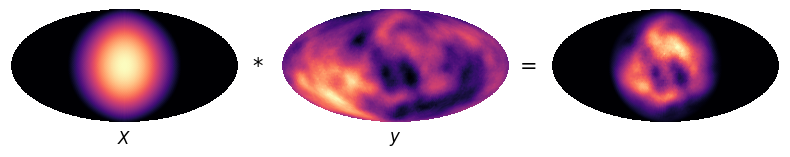

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))

for a in ax.flatten():
    plt.setp(a.spines.values(), visible=False)
    a.tick_params(left=False, labelleft=False)
    a.tick_params(bottom=False, labelbottom=False)
    a.patch.set_visible(False)


ax[0].imshow(projected_y * hemisphere_y * limb_y, origin="lower", cmap=cmap)
ax[1].imshow(moll_y, origin="lower", cmap=cmap)
ax[2].imshow(projected_y * hemisphere_y * limb_y * moll_y, origin="lower", cmap=cmap)
ax[2].text(
    -0.1, 0.5, "=", ha="center", va="center", transform=ax[2].transAxes, fontsize=15
)
ax[1].text(
    -0.1, 0.5, "*", ha="center", va="center", transform=ax[1].transAxes, fontsize=15
)
ax[0].set_xlabel("$X$", fontsize=12)
ax[1].set_xlabel("$y$", fontsize=12)

plt.tight_layout()

Or in orthographic view

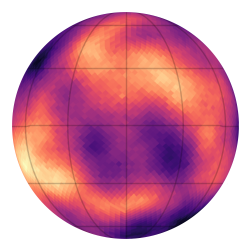

In [4]:
import healpy as hp
from spotter import core, show
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
show(star + y)

Using these principles, computing the map (and its observables such as the flux) at different inclinations or phases, simply consists in recomputing $X$, while the map of the star is unchanged. For example here is $X$ computed at 3 different inclinations and phases

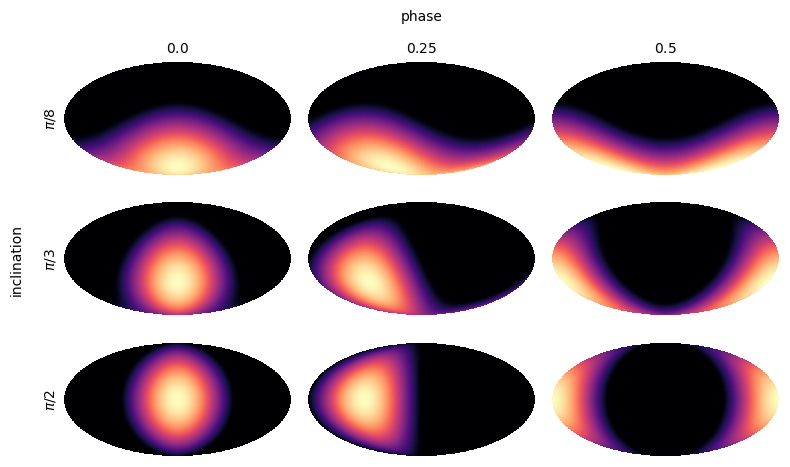

In [6]:
from spotter import light_curves

X = light_curves.design_matrix(star, 0.5)[0]

fig, ax = plt.subplots(3, 3, figsize=(8, 5))
incs = [np.pi / 8, np.pi / 3, np.pi / 2]
phases = [0, 0.25, 0.5]

for a in ax.flatten():
    plt.setp(a.spines.values(), visible=False)
    a.tick_params(left=False, labelleft=False)
    a.tick_params(bottom=False, labelbottom=False)
    a.patch.set_visible(False)

for i, inc in enumerate(incs):
    ax[i, 0].set_ylabel(
        ["$\pi/8$", "inclination\n\n$\pi/3$", "$\pi/2$"][i], fontsize=10
    )
    for j, phase in enumerate(phases):
        ax[0, j].set_title(["$0.0$", "phase\n\n$0.25$", "$0.5$"][j], fontsize=10)
        star = star.set(inc=inc)
        X = light_curves.design_matrix(star, phase)[0]
        Y = mollmap(X)
        ax[i, j].imshow(Y, cmap="magma")

plt.tight_layout()

And the resulting map in orthographic views

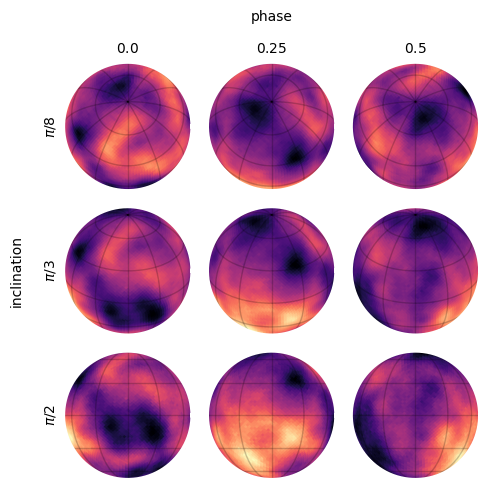

In [7]:
from spotter import light_curves

fig, ax = plt.subplots(3, 3, figsize=(5, 5))

for a in ax.flatten():
    plt.setp(a.spines.values(), visible=False)
    a.tick_params(left=False, labelleft=False)
    a.tick_params(bottom=False, labelbottom=False)
    a.patch.set_visible(False)

for i, inc in enumerate(incs):
    for j, phase in enumerate(phases):
        ax[0, j].set_title(["$0.0$", "phase\n\n$0.25$", "$0.5$"][j], fontsize=10)
        show(Star(y, inc=inc, period=1.0), ax=ax[i, j], phase=2 * np.pi * phase)
    ax[i, 0].set_ylabel(
        ["$\pi/8$", "inclination\n\n$\pi/3$", "$\pi/2$"][i], fontsize=10
    )

plt.tight_layout()

Using the same principle, we can compute the Doppler shift of each pixel and compute the integrated spectra of a spectral map (see the [Doppler maps tutorial](./spectral.ipynb)).